In [1]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '.jp-Notebook { padding-left: 0% !important; padding-right: 0% !important; width:100% !important; } '
    '</style>'
))

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

matplotlib.style.use("bmh")
font = {'size': 13}
matplotlib.rc('font', **font)

from IPython.display import display

%load_ext autoreload
%autoreload 2
    
import v0_2_0

/tmp/ipykernel_520828/2699245673.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
COLLECT_TS = "2024-08-24T16:10:31.710423758+00:00"
TARGET_PID = 444325
PATH = "figures/teastore"
FIGSIZE=(3.2, 3)
os.makedirs(PATH, exist_ok=True)

In [3]:
target = pd.read_csv(f"../data/{COLLECT_TS}/application-metrics/percentile_95.csv")

users = pd.read_csv(f"../data/{COLLECT_TS}/application-metrics/raw_users.csv")
users = users.sort_values(by="epoch_s")

MIN_TIMESTAMP, MAX_TIMESTAMP = target.epoch_s.min(), target.epoch_s.max()

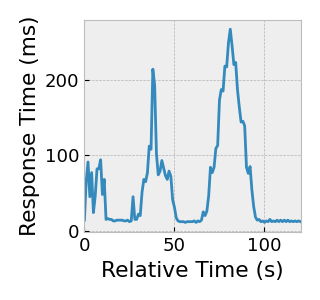

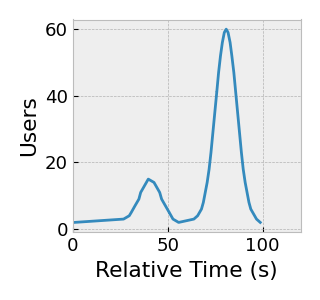

In [33]:
plt.figure(figsize=FIGSIZE)
plt.plot(target["epoch_s"] - MIN_TIMESTAMP, target["delay_ms"])
plt.xlim(XLIM)
plt.ylabel("Response Time (ms)")
plt.xlabel("Relative Time (s)")
plt.tight_layout()
plt.savefig(f"{PATH}/response_time.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=FIGSIZE)
plt.plot(users["epoch_s"] - MIN_TIMESTAMP, users["users_count"])
plt.xlim(XLIM)
plt.ylabel("Users")
plt.xlabel("Relative Time (s)")
plt.tight_layout()
plt.savefig(f"{PATH}/users.pdf", bbox_inches='tight', pad_inches=0)
plt.show()


# plt.plot(users["epoch_s"] - MIN_TIMESTAMP, users["users_count"])
# plt.axvline(x=38.5, color='red', linestyle='--', alpha=0.5)
# plt.axvline(x=46.5, color='red', linestyle='--', alpha=0.5)

# plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
# plt.xlabel("relative time (s)")
# plt.ylabel("response time ($\mu$s)")
# plt.show()

# Metrics

## Scheduling Statistics

In [6]:
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'sched/' in s, metric_files))
metrics = v0_2_0.metric_files_to_df(metric_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))

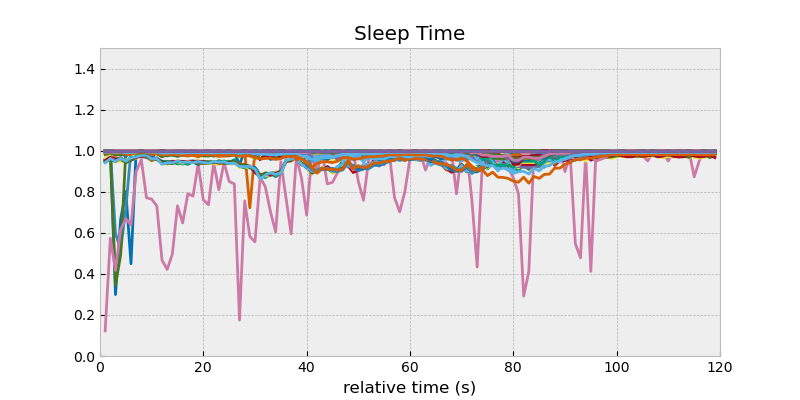

In [14]:
XLIM, YLIM = [0, 120], [0, 1.5]
START_TIMESTAMP = MIN_TIMESTAMP + XLIM[0]
END_TIMESTAMP = MIN_TIMESTAMP + XLIM[1]

plt.close("all")

threads = metrics.columns.str.replace(r"thread/\d+/(\d+?)/.*", r"\1", regex=True).unique().drop("epoch_s")
res = {}
for thread in threads:
    res[f"thread/{TARGET_PID}/{thread}/sched/sleep_time_rate"] = 1 - (metrics[f"thread/{TARGET_PID}/{thread}/sched/runtime_rate"] + metrics[f"thread/{TARGET_PID}/{thread}/sched/rq_time_rate"] + metrics[f"thread/{TARGET_PID}/{thread}/sched/block_time_rate"])

sleep_times = pd.DataFrame(res)
sleep_times["epoch_s"] = metrics["epoch_s"]
sleep_times = pd.merge(sleep_times, target, on="epoch_s", how="outer")
sleep_times = sleep_times.loc[(sleep_times["epoch_s"] > START_TIMESTAMP) & (sleep_times["epoch_s"] < END_TIMESTAMP), :]
corr = sleep_times.corr()["delay_ms"]
corr = corr.sort_values(ascending=False)
significant_corr = corr#[(corr.abs() > 0.5)]

plt.figure(figsize=(8, 4))
plt.title("Sleep Time")
plt.xlabel("relative time (s)")
threads = pd.Index([])
for col in significant_corr.index: 
    if "epoch_s" in col or "delay_ms" in col or "epoch_ms" in col: 
        continue
    threads = threads.append(pd.Index([col]))
    plt.plot(sleep_times["epoch_s"] - MIN_TIMESTAMP, sleep_times[col])
plt.xlim(XLIM)
plt.ylim(YLIM)
plt.show()

sleep_threads = threads
sleep_threads = set(sleep_threads.str.replace(r".*thread/\d+/(\d+)/.*", r"\1", regex=True).unique())

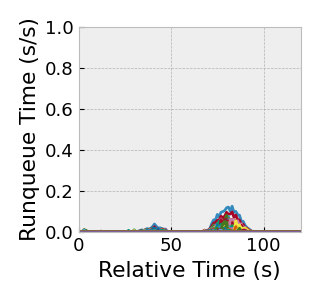

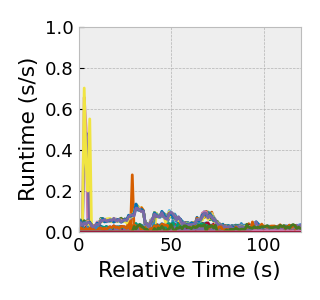

In [15]:
YLIM = [0, 1]
XLIM = [0, 120]

plt.close("all")

# Sched Runqueue

col_filter = metrics.columns[metrics.columns.str.contains("rq_time_rate")].append(pd.Index(["epoch_s"]))
rq = metrics.loc[:, col_filter]
rq = pd.merge(rq, target, on="epoch_s", how="outer")
corr = rq.corr()["delay_ms"]
corr = corr.sort_values(ascending=False)
significant_corr = corr#[corr.abs() > 0.3]

plt.figure(figsize=FIGSIZE)
plt.ylabel("Runqueue Time (s/s)")
plt.xlabel("Relative Time (s)")
threads = pd.Index([])
for col in significant_corr.index: 
    if "epoch_s" in col or "delay_ms" in col or "epoch_ms" in col: 
        continue
    threads = threads.append(pd.Index([col]))
    plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col])
plt.ylim(YLIM)
plt.xlim(XLIM)
plt.tight_layout()
plt.savefig(f"{PATH}/runqueue.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

rq_threads = threads

# Sched Runtime

col_filter = metrics.columns[metrics.columns.str.contains("runtime_rate")].append(pd.Index(["epoch_s"]))
rq = metrics.loc[:, col_filter]
rq = pd.merge(rq, target, on="epoch_s", how="outer")
corr = rq.corr()["delay_ms"]
corr = corr.sort_values(ascending=False)
significant_corr = corr#[corr.abs() > 0.3]

plt.figure(figsize=FIGSIZE)
plt.ylabel("Runtime (s/s)")
plt.xlabel("Relative Time (s)")
threads = pd.Index([])
for col in significant_corr.index:
    if "444401" in col: 
        continue
    if "epoch_s" in col or "delay_ms" in col or "epoch_ms" in col: 
        continue
    threads = threads.append(pd.Index([col]))
    plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col])
plt.xlim(XLIM)
plt.ylim(YLIM)
plt.tight_layout()
plt.savefig(f"{PATH}/runtime.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

runtime_threads = threads

# Sched Block Time

# col_filter = metrics.columns[metrics.columns.str.contains("block_time_rate")].append(pd.Index(["epoch_s"]))
# rq = metrics.loc[:, col_filter]
# rq = pd.merge(rq, target, on="epoch_s", how="outer")
# corr = rq.corr()["delay_ms"]
# corr = corr.sort_values(ascending=False)
# significant_corr = corr#[corr.abs() > 0.3]

# plt.figure(figsize=(8, 4))
# plt.title("Block Time")
# plt.xlabel("relative time (s)")
# threads = pd.Index([])
# for col in significant_corr.index: 
#     if "epoch_s" in col or "delay_ms" in col or "epoch_ms" in col: 
#         continue
#     threads = threads.append(pd.Index([col]))
#     plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col])
# plt.show()
# plt.ylim(YLIM)
# block_time_threads = threads

# rq_threads = set(rq_threads.str.replace(r".*thread/\d+/(\d+)/.*", r"\1", regex=True).unique())
# runtime_threads = set(runtime_threads.str.replace(r".*thread/\d+/(\d+)/.*", r"\1", regex=True).unique())
# block_time_threads = set(block_time_threads.str.replace(r".*thread/\d+/(\d+)/.*", r"\1", regex=True).unique())

## Epoll

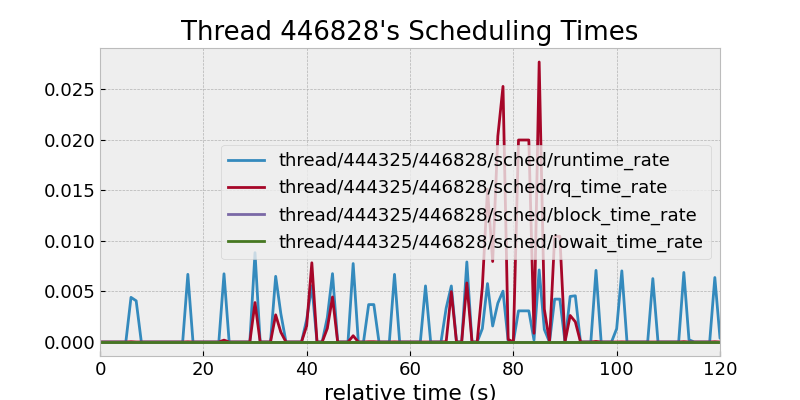

In [16]:
plt.close("all")

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'sched/' in s, metric_files))

for thread in [446828]:
    plt.figure(figsize=(8, 4))
    plt.title(f"Thread {thread}'s Scheduling Times")
    plt.xlabel("relative time (s)")
    files = metric_files[metric_files.str.contains(f"{TARGET_PID}/{thread}")]
    metrics = v0_2_0.metric_files_to_df(files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    rate_filter = metrics.columns[metrics.columns.str.contains("_rate")].append(pd.Index(["epoch_s"])).drop(f"thread/{TARGET_PID}/{thread}/sched/sleep_time_rate")
    metrics = metrics.loc[:, rate_filter]
    for col in metrics.columns:
        if col == "epoch_s": 
            continue
        plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=col)
    plt.legend()
    plt.xlim(0, MAX_TIMESTAMP - MIN_TIMESTAMP)
    plt.show()

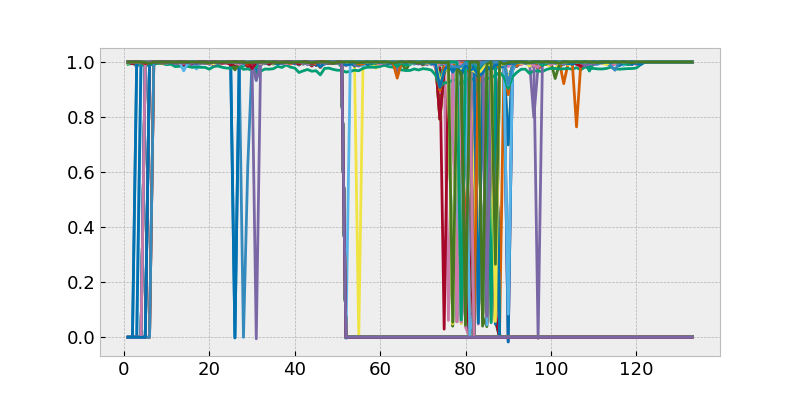

In [17]:
START_TIMESTAMP = MIN_TIMESTAMP

plt.close("all")

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread")
metric_files = pd.Series(filter(lambda s: 'epoll_' in s, metric_files))
metrics = v0_2_0.metric_files_to_df(metric_files, epoch_interval_s=(MIN_TIMESTAMP, MAX_TIMESTAMP))
col_filter = metrics.columns[metrics.columns.str.contains("stream_wait_rate")]
metrics = metrics.loc[metrics["epoch_s"] > START_TIMESTAMP, col_filter.append(pd.Index(["epoch_s"]))]

epolls = metrics.columns.str.replace(r"thread/\d+/\d+/.*/epoll_(\w+?)/.*", r"\1", regex=True).unique().drop("epoch_s")
threads = metrics.columns.str.replace(r"thread/\d+/(\d+?)/.*", r"\1", regex=True).unique().drop("epoch_s")

plt.figure(figsize=(8, 4))
epoll_threads = set()
for thread in threads:
    col_filter = metrics.columns[metrics.columns.str.contains(thread)]
    for col in col_filter:
        epoll_threads.add(thread)
        plt.plot(metrics["epoch_s"]-MIN_TIMESTAMP, metrics[col], label=thread)
plt.show()

## Thread

In [20]:
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/704111")
metric_files = pd.Series(filter(lambda s: 'epoll' in s, metric_files))
metric_files

Series([], dtype: float64)

In [19]:
threads = metric_files.str.replace(r".*thread/\d+/(\d+).*", r"\1", regex=True).unique()

AttributeError: Can only use .str accessor with string values!

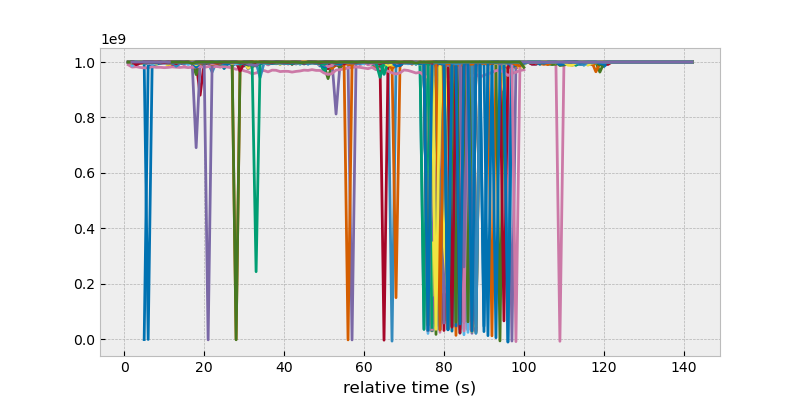

In [9]:
plt.figure(figsize=(8, 4))
plt.xlabel("relative time (s)")
for thread in threads[:200]:
    files = metric_files[metric_files.str.contains(f"/{thread}/")].to_list()
    metrics = v0_2_0.metric_files_to_df(files)
    plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[metrics.columns[metrics.columns.str.contains("stream_wait")][0]].diff())
plt.show()

## Global

In this section we analyze how long our service spends waiting for host `172.26.0.6:8080`.

1. Check how long each epoll resource is waiting for a connection that refers to this host
2. Sum the time each epoll waits for this host, to have a global wait time for this host
3. Get the average time each host is waiting

In [21]:
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/global/epoll")
metric_files = pd.Series(filter(lambda s: '172.24.0.5:8080' in s, metric_files))
epolls = metric_files.str.replace(r".*global/epoll/(\w+)/.*", r"\1", regex=True).unique()

res = pd.Series(dtype="Float64")
long = pd.DataFrame({"epoch_s": [], "variable": [], "value": []})
for epoll in epolls:
    files = metric_files[metric_files.str.contains(f"/{epoll}/")]
    metrics = v0_2_0.metric_files_to_df(files, epoch_interval_s=(MIN_TIMESTAMP, MAX_TIMESTAMP))
    swr_filter = metrics.columns[metrics.columns.str.contains("socket_wait_rate")]
    sub = metrics.loc[:, swr_filter.append(pd.Index(["epoch_s"]))]
    tmp = sub.melt(id_vars=["epoch_s"], value_vars=swr_filter)
    tmp["value"] = np.minimum(tmp["value"], 1)
    long = pd.concat([long, tmp])

/tmp/ipykernel_520828/3391567977.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(pcm, label="Relative Frequency", pad=0)


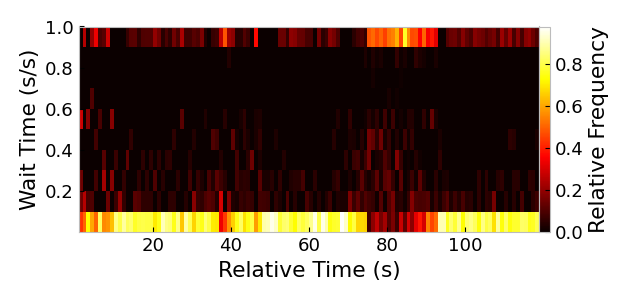

In [28]:
plt.close("all")

filtered = long.loc[(long["value"] > 0) & (long["epoch_s"] < MIN_TIMESTAMP + 120),:]
START, END = filtered["epoch_s"].min(), filtered["epoch_s"].max()
h, xedges, yedges = np.histogram2d(filtered["epoch_s"], filtered["value"], bins=[END-START, 10])
row_sums = h.sum(axis=1)
h = h / row_sums[:, np.newaxis]

fig = plt.figure(figsize=(6.4, 3))
# fig, axes = plt.subplots(nrows=1, figsize=(8, 4), layout='constrained')
plt.grid(False)
pcm = plt.pcolormesh(xedges - MIN_TIMESTAMP, yedges, h.T, cmap="hot")
# plt.axvline(x=38.5, color='green', linestyle='--')
fig.colorbar(pcm, label="Relative Frequency", pad=0)
plt.ylabel("Wait Time (s/s)")
plt.xlabel("Relative Time (s)")
plt.tight_layout()
plt.savefig(f"{PATH}/timeseries_histogram.pdf", bbox_inches='tight', pad_inches=0)
plt.show()